In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

warnings.simplefilter("ignore")
%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

## 0.Data load

In [2]:
# # choongs load
# df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [3]:
# ## osy load
# df_cust = pd.read_csv("../../LPOINT_BIG_COMP_01_DEMO.csv")
# df_pdde = pd.read_csv("../../LPOINT_BIG_COMP_02_PDDE.csv")
# df_cop_u = pd.read_csv("../../LPOINT_BIG_COMP_03_COP_U.csv")
# df_pd_clac = pd.read_csv("../../LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [4]:
# rnch load
df_cust = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_pdde = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv")
df_cop_u = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_pd_clac = pd.read_csv("./LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

# 1.Domain Clustering Function
---

In [31]:
#DBSCAN을 통해 이상치 제거
def delete_outlier_DBSCAN(df_pdde, df_pd_clac):
    df_pdde_pd_clac = df_pdde.merge(df_pd_clac, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
               values='buy_am',
               index='cust',
               columns='clac_hlv_nm',
               aggfunc='sum',
               fill_value=0)
    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()

    eps_ratio_outlier_dict = dict()
    for epss in tqdm(list(np.arange(0.05, 0.15, 0.01))):
        dbscan = DBSCAN(eps = epss, min_samples = 30, metric = "euclidean")
        dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
        ratio_outlier = np.unique(dbscan_labels, return_counts=True)[1][0]/np.unique(dbscan_labels, return_counts=True)[1].sum()
        eps_ratio_outlier_dict[epss] = abs(ratio_outlier-0.05) #딕셔너리 Value는 이상치-0.05의 절댓값 -> 즉 0.05에 가장 가까운 값을 찾는다.

    best_eps = min(eps_ratio_outlier_dict,key=eps_ratio_outlier_dict.get)
    

    dbscan = DBSCAN(eps = best_eps, min_samples = 30, metric = "euclidean")
    dbscan_labels = dbscan.fit_predict(df_spt_2.iloc[:, 1:])
    df_spt_2['outlier'] = dbscan_labels

    df_spt_not_outlier_cust = df_spt_2[df_spt_2['outlier']==0]['cust']
    
    return df_spt_not_outlier_cust



# 누락 데이터 삭제
def check_on_off(df_main, df, key="cust", col_nm="chnl_dv"):
    df_new = pd.DataFrame(df.groupby(key)[col_nm].apply(lambda x:list(set(x))))
    return df_main.merge(df_new, how="left", on=key).dropna(subset=["chnl_dv"])



# on/off 분류
def split_on_off(df, col_nm="chnl_dv"):
    df[col_nm] = df[col_nm].apply(lambda x: x[0] if len(x)==1 else 0)
    df_off = df.loc[df[col_nm]==1] ##off
    df_on = df.loc[df[col_nm]==2] ##on
    df_onf = df.loc[df[col_nm]==0] ##onf

    df_not_off = pd.concat([df_on, df_onf], axis=0, ignore_index=True)


    return df_off, df_not_off #off, not_off

def classification_buy_am(x, std_points):
    if x <= std_points[0]:
        return "D"
    elif std_points[0] < x <= std_points[1]:
        return "C"
    elif std_points[1] < x <= std_points[2]:
        return "B"
    else:
        return "A"

def split_buy_amount_by_4(df_main, df_sub, key='cust', col_nm='buy_am'):
    df_new = df_sub.groupby([key], as_index=False)[col_nm].sum()
    df_new2 = df_main.merge(df_new, on='cust', how='left')
    df_new2["am_class"] = df_new2[col_nm].apply(classification_buy_am, std_points=np.quantile(df_new2[col_nm], [.25, .5, .75]))
    

    df_A = df_new2[df_new2['am_class']=='A']
    df_B = df_new2[df_new2['am_class']=='B']
    df_C = df_new2[df_new2['am_class']=='C']
    df_D = df_new2[df_new2['am_class']=='D']
    
    return df_A, df_B, df_C, df_D
    

# def domain_clustering_ver2(df_main, df_sub, df_sub2):
def domain_clustering_ver2(df_main, df_sub, not_outlier_cust):

    # not_outlier_cust = delete_outlier_DBSCAN(df_sub, df_sub2)

    df_main = df_main.loc[df_main['cust'].isin(not_outlier_cust.values.tolist())]

    df = check_on_off(df_main, df_sub)

    df_off, df_not_off= split_on_off(df)

    
    df_off_A, df_off_B, df_off_C, df_off_D  = split_buy_amount_by_4(df_off, df_sub)
    df_not_off_A, df_not_off_B, df_not_off_C, df_not_off_D  = split_buy_amount_by_4(df_not_off, df_sub)

    df_off_A['cluster'] = 0
    df_off_B['cluster'] = 1
    df_off_C['cluster'] = 2
    df_off_D['cluster'] = 3
    df_not_off_A['cluster'] = 4
    df_not_off_B['cluster'] = 5
    df_not_off_C['cluster'] = 6
    df_not_off_D['cluster'] = 7

    df_off_A_label = df_off_A[['cust', 'cluster']]
    df_off_B_label = df_off_B[['cust', 'cluster']]
    df_off_C_label = df_off_C[['cust', 'cluster']]
    df_off_D_label = df_off_D[['cust', 'cluster']]
    df_not_off_A_label = df_not_off_A[['cust', 'cluster']]
    df_not_off_B_label = df_not_off_B[['cust', 'cluster']]
    df_not_off_C_label = df_not_off_C[['cust', 'cluster']]
    df_not_off_D_label = df_not_off_D[['cust', 'cluster']]
    

        
    return df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label

In [33]:
df_not_outlier = delete_outlier_DBSCAN(df_pdde, df_pd_clac)
df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label = domain_clustering_ver2(df_cust, df_pdde, df_not_outlier) 

  0%|          | 0/10 [00:00<?, ?it/s]

# 2.K means Clustering Function

In [34]:
### 아래 함수에서 각각의 데이터프레임 넣어서 각각에 대한 군집 뽑아내서 붙이려고 하나로 합치고 시작했슴당

df_list = [df_off_A_label, df_off_B_label, df_off_C_label, df_off_D_label, df_not_off_A_label, df_not_off_B_label, df_not_off_C_label, df_not_off_D_label]
df_dom_clustered = pd.concat(df_list, ignore_index=True)

In [35]:
df_main = pd.merge(df_pdde, df_pd_clac, how='left', on='pd_c')

In [36]:
result_srs = (df_pdde["cop_c"].value_counts() >= 430000)
clusters = []
for idx in result_srs.index:
    if result_srs[idx]:
        clusters.append(idx)
df_pdde.loc[df_pdde["cop_c"].isin(clusters)]

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
3981006,M655525572,E03012401343,2,A03,NaN,PD0324,20211231,23,7490.0,1
3981007,M655525572,E03012401343,2,A03,NaN,PD1161,20211231,23,1090.0,1
3981008,M655525572,E03012401343,2,A03,NaN,PD1387,20211231,23,1690.0,1
3981009,M655525572,E03012401343,2,A03,NaN,PD1499,20211231,23,13280.0,1


In [37]:
df_pd_clac

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
0,PD0001,소파,가구,거실가구
1,PD0002,스툴/리빙의자,가구,거실가구
2,PD0003,탁자,가구,거실가구
3,PD0004,장식장/진열장,가구,거실가구
4,PD0005,기타가구,가구,기타가구
...,...,...,...,...
1928,PD1929,여성향수,화장품/뷰티케어,향수
1929,PD1930,남성향수,화장품/뷰티케어,향수
1930,PD1931,남녀공용향수,화장품/뷰티케어,향수
1931,PD1932,남성향수세트,화장품/뷰티케어,향수


In [38]:
def merging(df1, df2):
    return pd.merge(df1, df2, how='left', on='cust')


def pivoting(df_main, df): 
    columns_default = list(df_main['clac_hlv_nm'].unique())
    df_res = pd.DataFrame(columns=columns_default)
    df_pt = pd.pivot_table(data=df,
                           values='buy_am',
                           index='cust',
                           columns='clac_hlv_nm',
                           aggfunc='sum',
                           fill_value=0)
    df_res = pd.concat([df_res, df_pt], ignore_index=False)
    df_res.fillna(0, inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_res)
    df_spt = pd.DataFrame(scaler.transform(df_res), index=df_pt.index, columns=df_res.columns)
    return df_spt


def get_inertia(df, k):
    Kmeans = KMeans(n_clusters=k, random_state=200)
    Kmeans.fit(df)
    return Kmeans.inertia_

def get_clusters_k(df):
    k_range = range(2, 20)
    k_result = None

    for k in k_range:
        minus = get_inertia(df, k) - get_inertia(df, k + 1)
        if k == 2:
            minus_before = minus
            minus_rate_max = 0
        else:
            minus_rate = minus_before - minus
            if minus_rate > minus_rate_max:
                k_result = k
                minus_rate_max = minus_rate
            minus_before = minus

    return k_result


def clustering(df_main, df_dom_clustered):
    df = merging(df_main, df_dom_clustered)
    df_result = pd.DataFrame()
    db_clustered_k = len(df_dom_clustered['cluster'].unique())
    for i in range(db_clustered_k):
        df_ = df[df['cluster']==i]
        df_pt = pivoting(df_main, df_)
        k = get_clusters_k(df_pt)
        Kmeans_ = KMeans(n_clusters=k, random_state=200)
        Kmeans_.fit(df_pt)
        cluster = Kmeans_.predict(df_pt)
        df_pt['buy_am_cluster'] = cluster
        
        ### 최소 군집 수가 이뤄지지 않으면 버리기 ###
        result_srs = (df_pt["buy_am_cluster"].value_counts() >= 4)
        clusters = []
        for idx in result_srs.index:
            if result_srs[idx]:
                clusters.append(idx)
        df_pt = df_pt.loc[df_pt["buy_am_cluster"].isin(clusters)]
        ##########################################
        
        df_result = pd.concat([df_result, df_pt])
        # break
    df_result.fillna(0, inplace=True)
    df_result.reset_index(drop=False, inplace=True)
    df_result = df_result.merge(df_dom_clustered, how="left", on="cust")
    df_clustered_final = df_result.loc[:, ['cust', 'buy_am_cluster', 'cluster']]
    comb_cluster = df_clustered_final.iloc[:,1].astype(str)+df_clustered_final.iloc[:,2].astype(str)
    df_clustered_final["comb_cluster"] = comb_cluster.apply(lambda x: comb_cluster.unique().tolist().index(x))
    
    return df_clustered_final


In [39]:
# df_total_pt = pivoting(df_main)
# mms_scaler = fit_scaler(df_total_pt)
# transform_scaler(df_total_pt, mms_scaler)
df_clustering = clustering(df_main, df_dom_clustered)

In [40]:
df_clustering["comb_cluster"].value_counts()

0     2689
22    2410
14    1572
47    1559
3     1207
      ... 
29     107
24      98
31      92
30      76
13      55
Name: comb_cluster, Length: 49, dtype: int64

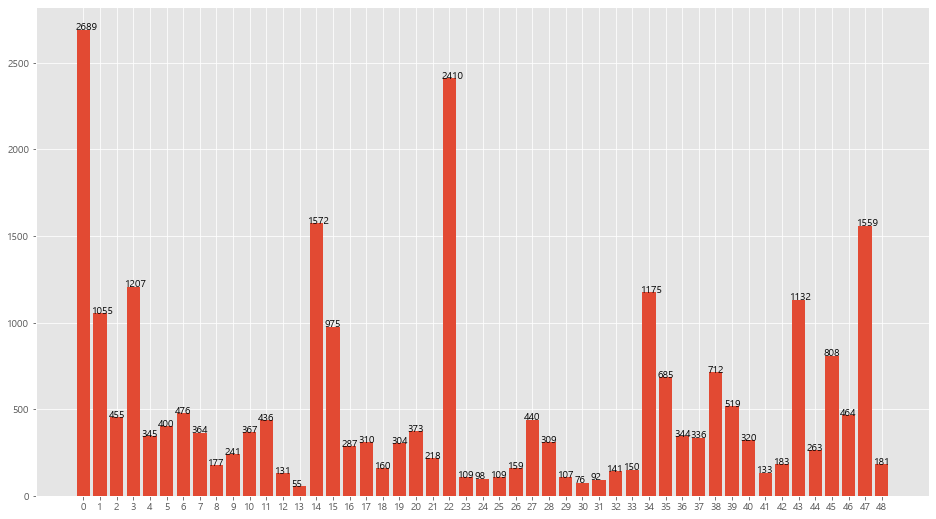

In [41]:
plt.bar(x=df_clustering["comb_cluster"].value_counts().index, height=df_clustering["comb_cluster"].value_counts().values)
for x in range(0,len(df_clustering["comb_cluster"].value_counts())):
    plt.text(x=x-.5, y=df_clustering["comb_cluster"].value_counts()[x],s=f"{df_clustering['comb_cluster'].value_counts()[x]}")
plt.xticks(range(0,len(df_clustering["comb_cluster"].value_counts())))
plt.show()

In [ ]:
# df_clustering.to_csv("./predict_result/clustering_result.csv",index=False)

# 3-1.Recommend Ver 1.

In [ ]:
#함수화
import copy
from tqdm.notebook import tqdm

##2만여명 고객 품목별 구매금액 Scale
def pivot_table_for_recommend(df_pd, df_pdc):
    df_norm = df_pd.loc[df_pdde["cust"].isin(delete_outlier_DBSCAN(df_pd, df_pdc).values.tolist())]
    df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
                values='buy_am',
                index='cust',
                columns='clac_hlv_nm',
                aggfunc='sum',
                fill_value=0)

    df_pt.reset_index(inplace=True)

    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()
    return df_spt_2


##클러스터 별로 나누는 함수 정의 필요.


##가까운 3명 뽑기 위한 dist map생성 df<-클러스터별로 나누는 함수가 들어간다.
def make_dist_map_pick_near_3(df):
    dist_map = cdist(df.iloc[:,1:], df.iloc[:,1:], metric='cosine')
    dist_map_df = pd.DataFrame(dist_map, index=df["cust"], columns=df["cust"])

    temp_dict = dict()
    for i in dist_map_df.index.tolist():
        temp_dict[i] = dist_map_df.loc[i,:].sort_values()[1:4].index.tolist()

    df_cust_near = pd.DataFrame(temp_dict)
    df_cust_near_result = df_cust_near.T

    return df_cust_near_result

def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

def make_cust_recommend_item(df, df_pd, df_pdc, opt_pd_nm=True):
    
    recommend_dict = {}
    except_list = []

    for cust_num in tqdm(df.index):
    # sample은 이웃의 모든 구매 목록 리스트
        sample = df_pd.loc[df_pd["cust"].isin(df.loc[cust_num,:].tolist())]['pd_c'].value_counts()

    # sample_result는 이웃의 모든 구매 목록 리스트와 Target(M000261625)의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
        sample_result = set(sample.index)-set(df_pd.loc[df_pdde['cust']==cust_num]['pd_c'].values)

    # df_smp
        df_smp = pd.DataFrame()
        df_smp["neighbor_list"] = list(sample_result)
        df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
        if opt_pd_nm:
            df_smp_nm = code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pdc)
        else:
            df_smp_nm = copy.deepcopy(df_smp)
        try:
            # sample_dff = pd.DataFrame(df_smp_nm, "neighbor_list", df_pd_clac)[0:3]['neighbor_list'].T
            sample_dff = df_smp_nm.iloc[:5,0].values.tolist()
            recommend_dict[cust_num] = sample_dff
        except:
            except_list.append((cust_num,len(df_smp_nm.iloc[:,0].values)))
            continue

    final_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recommend_dict.items() ]))
    final_df = final_result_df.T

    return final_df, except_list

In [ ]:
# df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac)
df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac)

cluster_recommend_dict = dict()
cluster_exception = dict()

for clust_no in tqdm(df_clustering["comb_cluster"].unique()):
    ## -- 클러스터 1개 당 df 정의
    clust_list = df_clustering.loc[df_clustering["comb_cluster"]==clust_no]["cust"].values.tolist()
    df_similar = df_normal_dist.loc[df_normal_dist["cust"].isin(clust_list)]
    
    ## PRODUCT NAME
    cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(make_dist_map_pick_near_3(df_similar),df_pdde, df_pd_clac, True)
    ## PRODUCT CODE
    # cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(make_dist_map_pick_near_3(df_similar),df_pdde, df_pd_clac, False)
    
c_rd = copy.deepcopy(cluster_recommend_dict)
c_ex = copy.deepcopy(cluster_exception)

In [ ]:
c_rd[0]
# pd.DataFrame(c_ex)

,0,1,2
M000261625,기타남성의류세트,남성스포츠티셔츠,기타건과일
M000508243,기타남성의류세트,성인침구세트,한식
M001694463,즉석무침반찬,젤리,양식
M001697472,국산담배,수입맥주,국물용기라면
M001729158,종량제봉투,생활잡화균일가,일반스낵
...,...,...,...
M998346579,여성티셔츠/탑,디저트,젤리
M999213998,비빔봉지라면,방울토마토,냉동떡볶이
M999227380,기타아웃도어/레저용품,기타파티/팬시용품,남성티셔츠
M999340261,기타컴퓨터액세서리,키보드,국산담배


# 3-2.Recommend Ver 2.

In [45]:
df_not_outlier

0        M000034966
1        M000136117
2        M000201112
3        M000225114
4        M000261625
            ...    
26912    M999599111
26913    M999673157
26914    M999770689
26915    M999849895
26916    M999962961
Name: cust, Length: 25611, dtype: object

In [50]:
#함수화
import copy
from tqdm.notebook import tqdm

##2만여명 고객 품목별 구매금액 Scale
# def pivot_table_for_recommend(df_pd, df_pdc):
#     df_norm = df_pd.loc[df_pd["cust"].isin(delete_outlier_DBSCAN(df_pd, df_pdc).values.tolist())]
#     df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
#     df_pt = pd.pivot_table(data=df_pdde_pd_clac,
#                 values='buy_am',
#                 index='cust',
#                 columns='clac_hlv_nm',
#                 aggfunc='sum',
#                 fill_value=0)

#     df_pt.reset_index(inplace=True)

#     scaler = MinMaxScaler()
#     scaler.fit(df_pt.iloc[:,1:])
#     df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
#     df_spt_2 =  df_spt.reset_index()
#     return df_spt_2

def pivot_table_for_recommend(df_pd, df_pdc, not_outlier_srs):
    df_norm = df_pd.loc[df_pd["cust"].isin(not_outlier_srs.values)]
    df_pdde_pd_clac = df_norm.merge(df_pdc, how='left', on='pd_c')
    df_pt = pd.pivot_table(data=df_pdde_pd_clac,
                values='buy_am',
                index='cust',
                columns='clac_hlv_nm',
                aggfunc='sum',
                fill_value=0)

    df_pt.reset_index(inplace=True)
    return df_pt

def min_max_pred(df_pt):
    scaler = MinMaxScaler()
    scaler.fit(df_pt.iloc[:,1:])
    df_spt = pd.DataFrame(scaler.transform(df_pt.iloc[:,1:]), index=df_pt["cust"], columns=df_pt.columns[1:])
    df_spt_2 =  df_spt.reset_index()
    return df_spt_2


##클러스터 별로 나누는 함수 정의 필요.
def find_nearest_3(df_clust, df_normal_dist, clust_no, opt_test=None):
    
    clust_list = df_clust.loc[df_clust["comb_cluster"]==clust_no]["cust"].values.tolist()
    df_similar = df_normal_dist.loc[df_normal_dist["cust"].isin(clust_list)]
    df_norm_similar = min_max_pred(df_similar)
    
    dist_map = cdist(df_norm_similar.iloc[:,1:], df_norm_similar.iloc[:,1:], metric='cosine')
    near_indexes = dist_map.argsort()[:,1:4]
    near_loc_idx = [list(map(lambda x: df_norm_similar.iloc[x,0], near_idx)) for near_idx in near_indexes]
    df_near = pd.DataFrame(near_loc_idx, index=df_norm_similar["cust"].values)

    return df_near


def code_to_name(df :pd.DataFrame, col_name :str, df_pdc :pd.DataFrame):
    df_result = copy.deepcopy(df)
    matching_series = df_pdc.set_index("pd_c")
    df_result[col_name] = df[col_name].apply(lambda x: matching_series.loc[x, "pd_nm"])
    return df_result

def make_cust_recommend_item(df_near, df_pd, df_pdc, opt_pd_nm=True):
    
    recommend_dict = {}
    except_list = []

    for cust_num in df_near.index:
    # sample은 이웃의 모든 구매 목록 리스트
        sample = df_pd.loc[df_pd["cust"].isin(df_near.loc[cust_num,:].tolist())]['pd_c'].value_counts()

    # sample_result는 이웃의 모든 구매 목록 리스트와 Target(M000261625)의 구매 목록 리스트를 비교해 Target이 구매하지 않은 품목을 찾음
        sample_result = set(sample.index)-set(df_pd.loc[df_pdde['cust']==cust_num]['pd_c'].values)

    # df_smp
        df_smp = pd.DataFrame()
        df_smp["neighbor_list"] = list(sample_result)
        df_smp["neighbor_buy_am"] = list(map(lambda x: sample[x] ,list(sample_result)))
        if opt_pd_nm:
            df_smp_nm = code_to_name(df_smp.sort_values("neighbor_buy_am", ascending=False), "neighbor_list", df_pdc)
        else:
            df_smp_nm = copy.deepcopy(df_smp)
        try:
            # sample_dff = pd.DataFrame(df_smp_nm, "neighbor_list", df_pd_clac)[0:3]['neighbor_list'].T
            sample_dff = df_smp_nm.iloc[:5,0].values.tolist()
            recommend_dict[cust_num] = sample_dff
        except:
            except_list.append((cust_num,len(df_smp_nm.iloc[:,0].values)))
            continue

    final_result_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in recommend_dict.items() ]))
    final_df = final_result_df.T

    return final_df, except_list

In [52]:
df_normal_dist = pivot_table_for_recommend(df_pdde, df_pd_clac, df_not_outlier)

In [54]:
df_normal_dist

clac_hlv_nm,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000034966,0,0,0,6960,...,0,0,0,0,0
1,M000136117,0,0,0,0,...,27000,4997600,56800,154000,209000
2,M000201112,0,0,0,0,...,0,0,0,0,0
3,M000225114,0,0,0,0,...,93700,334000,0,0,323000
4,M000261625,0,0,0,0,...,329600,27800,503000,0,2887000
...,...,...,...,...,...,...,...,...,...,...,...
25606,M999599111,0,17900,0,9980,...,0,0,0,0,0
25607,M999673157,0,0,0,0,...,6500,1673000,0,0,116000
25608,M999770689,0,108300,43000,0,...,69390,28500,0,0,0
25609,M999849895,0,0,7400,0,...,60800,41800,0,0,0


In [53]:
min_max_pred(df_normal_dist)

clac_hlv_nm,cust,가구,건강식품,건강용품,건해산물,...,테넌트/음식점,패션잡화,퍼스널케어,헬스/피트니스,화장품/뷰티케어
0,M000034966,0.0,0.000000,0.000000,0.004270,...,0.000000,0.000000,0.000000,0.000000,0.000000
1,M000136117,0.0,0.000000,0.000000,0.000000,...,0.011651,0.051421,0.014573,0.092017,0.007420
2,M000201112,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,M000225114,0.0,0.000000,0.000000,0.000000,...,0.040433,0.003437,0.000000,0.000000,0.011467
4,M000261625,0.0,0.000000,0.000000,0.000000,...,0.142228,0.000286,0.129056,0.000000,0.102489
...,...,...,...,...,...,...,...,...,...,...,...
25606,M999599111,0.0,0.004265,0.000000,0.006123,...,0.000000,0.000000,0.000000,0.000000,0.000000
25607,M999673157,0.0,0.000000,0.000000,0.000000,...,0.002805,0.017214,0.000000,0.000000,0.004118
25608,M999770689,0.0,0.025802,0.007665,0.000000,...,0.029943,0.000293,0.000000,0.000000,0.000000
25609,M999849895,0.0,0.000000,0.001319,0.000000,...,0.026236,0.000430,0.000000,0.000000,0.000000


In [55]:
cluster_recommend_dict = dict()
cluster_exception = dict()

for clust_no in tqdm(df_clustering["comb_cluster"].unique()):
    near_3cust = find_nearest_3(df_clustering, df_normal_dist, clust_no)
    cluster_recommend_dict[clust_no], cluster_exception[clust_no] = make_cust_recommend_item(near_3cust, df_pdde, df_pd_clac, True)
    
c_rd = copy.deepcopy(cluster_recommend_dict)
c_ex = copy.deepcopy(cluster_exception)

  0%|          | 0/49 [00:00<?, ?it/s]

In [56]:
import pickle
from datetime import datetime

with open(f"./predict_result/recommend_dict_{datetime.today().strftime('%y%m%d%H%M%S')}.pickle", "wb") as f:
    pickle.dump(c_rd, f, pickle.HIGHEST_PROTOCOL)
    
with open(f"./predict_result/exception_list_{datetime.today().strftime('%y%m%d%H%M%S')}.pickle", "wb") as f:
    pickle.dump(c_ex, f, pickle.HIGHEST_PROTOCOL)

In [57]:
c_rd[48]

,0,1,2,3,4
M002867247,남성스포츠점퍼/재킷,남성등산점퍼/재킷,NaN,NaN,NaN
M009682567,기타남성의류세트,남성스포츠스웨트셔츠/후드/집업,여성속옷세트,일반미,냉장핫도그/핫바류
M017524395,여성일반지갑,야구모자,캐쥬얼크로스백,여성등산티셔츠/탑,남성등산바지
M025168868,기타생활서비스,국물용기라면,감자스낵,일반빵,사이다
M035670981,옥수수스낵,봉투보증금,일반스낵,콜라,남아의류세트
...,...,...,...,...,...
M977028904,즉석죽,기타남성의류세트,베이커리,영화/문화모바일상품권,샐러드류
M983457029,기타남성의류세트,스파/워터파크이용권,남성남방셔츠,남성골프티셔츠,남성코트
M995885121,남성골프티셔츠,식빵,국산맥주,일반소주,일반계란
M998129365,유아동런닝/트레이닝화,기타등산용품,남성팬티,성인이불/이불커버,스케이트보드/킥보드


In [58]:
c_rd[0]

,0,1,2,3,4
M000261625,쿠키,커피음료,동남아식,생수,스틱과자
M000350564,기타남성의류세트,봉투보증금,기타패션잡화,여성골프의류세트,골프필드용품
M000508243,국산담배,기타남성의류세트,수입담배,여성티셔츠/탑,스포츠음료
M001694463,남성티셔츠,기타전통과자,디저트,기타남성의류세트,기타온장조리
M001697472,국산담배,샐러드류,스킨/토너,기타파티/팬시용품,일반계란
...,...,...,...,...,...
M997957983,임대매출,푸드코트한식,여아티셔츠/탑,일식,국산담배
M998346579,커피음료,디저트,국물봉지라면,콜라,냉장커피차음료
M999227380,여성티셔츠/탑,다기류,국물용기라면,냉장핫도그/핫바류,거실수예소품
M999340261,기타모바일액세서리,기타컴퓨터액세서리,키보드,기타아웃도어/레저용품,체리


# 4.Concat result

In [59]:
pd.concat(c_rd.values(), axis=0).to_csv("./predict_result/total_recommend_independent_minmax.csv", encoding="euc-kr")